In [2]:
import torch
#from torchviz import make_dot
from torchvision import datasets
from torch import optim
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import requests
#import cv2
import h5py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Using device: cpu
Loaded 26214 training samples and 3276 validation samples
Epoch 1/10, Train Loss: 0.6010, Validation Loss: 0.7234, Train Accuracy: 0.6922, Validation Accuracy: 0.5972
Epoch 2/10, Train Loss: 0.5621, Validation Loss: 0.5390, Train Accuracy: 0.7269, Validation Accuracy: 0.7331
Epoch 3/10, Train Loss: 0.5432, Validation Loss: 0.7157, Train Accuracy: 0.7368, Validation Accuracy: 0.6030
Epoch 4/10, Train Loss: 0.5189, Validation Loss: 0.7475, Train Accuracy: 0.7526, Validation Accuracy: 0.6336
Epoch 5/10, Train Loss: 0.4954, Validation Loss: 0.9815, Train Accuracy: 0.7704, Validation Accuracy: 0.5486
Epoch 6/10, Train Loss: 0.4674, Validation Loss: 0.7907, Train Accuracy: 0.7877, Validation Accuracy: 0.6290
Epoch 7/10, Train Loss: 0.4379, Validation Loss: 3.6226, Train Accuracy: 0.8014, Validation Accuracy: 0.5065
Epoch 8/10, Train Loss: 0.4140, Validation Loss: 2.0561, Train Accuracy: 0.8170, Validation Accuracy: 0.5168
Epoch 9/10, Train Loss: 0.3890, Validation Loss: 3.6

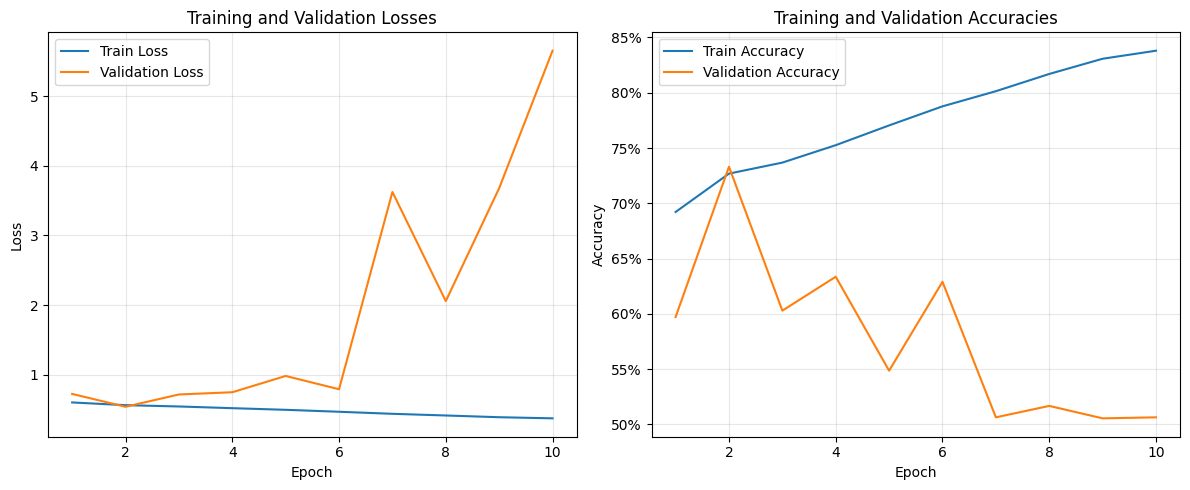

In [ ]:
def load_medical_data_subset(sample_ratio=0.1, random_state=42):

    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_x.h5', 'r') as f:
        train_length = len(f['x'])
       
        sample_size = int(train_length * sample_ratio)
        indices = np.random.RandomState(random_state).choice(train_length, sample_size, replace=False)
        indices.sort()  
        
        tr_images = []
        for idx in indices:
            tr_images.append(f['x'][idx].astype(np.float32))
        tr_images = torch.from_numpy(np.array(tr_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_y.h5', 'r') as f:
        tr_targets = []
        for idx in indices:
            tr_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        tr_targets = torch.from_numpy(np.array(tr_targets))
    
   
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_x.h5', 'r') as f:
        val_length = len(f['x'])
       
        val_sample_size = int(val_length * sample_ratio)
        val_indices = np.random.RandomState(random_state).choice(val_length, val_sample_size, replace=False)
        val_indices.sort()
        
        val_images = []
        for idx in val_indices:
            val_images.append(f['x'][idx].astype(np.float32))
        val_images = torch.from_numpy(np.array(val_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_y.h5', 'r') as f:
        val_targets = []
        for idx in val_indices:
            val_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        val_targets = torch.from_numpy(np.array(val_targets))
    
    print(f"Loaded {len(tr_images)} training samples and {len(val_images)} validation samples")
    return tr_images, tr_targets, val_images, val_targets

class MedicalDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255  
        x = x.view(-1, 96*96*3) 
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)


tr_images, tr_targets, val_images, val_targets = load_medical_data_subset(sample_ratio=0.1)

train_dataset = MedicalDataset(tr_images, tr_targets)
valid_dataset = MedicalDataset(val_images, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Linear(96 * 96 * 3, 1000),
    nn.BatchNorm1d(1000),
    nn.Dropout(.5),
    nn.ReLU(),  
    nn.Linear(1000, 1000),
    nn.BatchNorm1d(1000),
    nn.Dropout(.5),
    nn.ReLU(), 
    nn.Linear(1000, 1000),
    nn.BatchNorm1d(1000),
    nn.Dropout(.5),
    nn.ReLU(),   
    nn.Linear(1000, 2)  
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

def accuracy(outputs, targets):
    _, predictions = torch.max(outputs, 1)  
    correct = (predictions == targets).sum().item()
    return correct / targets.size(0)

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)  
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)


n_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = validate(model, valid_dataloader, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True, alpha=0.3)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

Loaded 26214 training samples and 3276 validation samples
Epoch 1/10, Train Loss: 0.6222, Validation Loss: 0.6102, Train Accuracy: 0.6756, Validation Accuracy: 0.6533
Epoch 2/10, Train Loss: 0.5879, Validation Loss: 0.5352, Train Accuracy: 0.7083, Validation Accuracy: 0.7359
Epoch 3/10, Train Loss: 0.5640, Validation Loss: 0.6308, Train Accuracy: 0.7264, Validation Accuracy: 0.6400
Epoch 4/10, Train Loss: 0.5526, Validation Loss: 0.8098, Train Accuracy: 0.7345, Validation Accuracy: 0.5966
Epoch 5/10, Train Loss: 0.5322, Validation Loss: 0.6307, Train Accuracy: 0.7491, Validation Accuracy: 0.6947
Epoch 6/10, Train Loss: 0.5145, Validation Loss: 0.6557, Train Accuracy: 0.7596, Validation Accuracy: 0.6959
Epoch 7/10, Train Loss: 0.4940, Validation Loss: 0.8321, Train Accuracy: 0.7759, Validation Accuracy: 0.6476
Epoch 8/10, Train Loss: 0.4799, Validation Loss: 1.3976, Train Accuracy: 0.7810, Validation Accuracy: 0.5507
Epoch 9/10, Train Loss: 0.4539, Validation Loss: 3.7266, Train Accurac

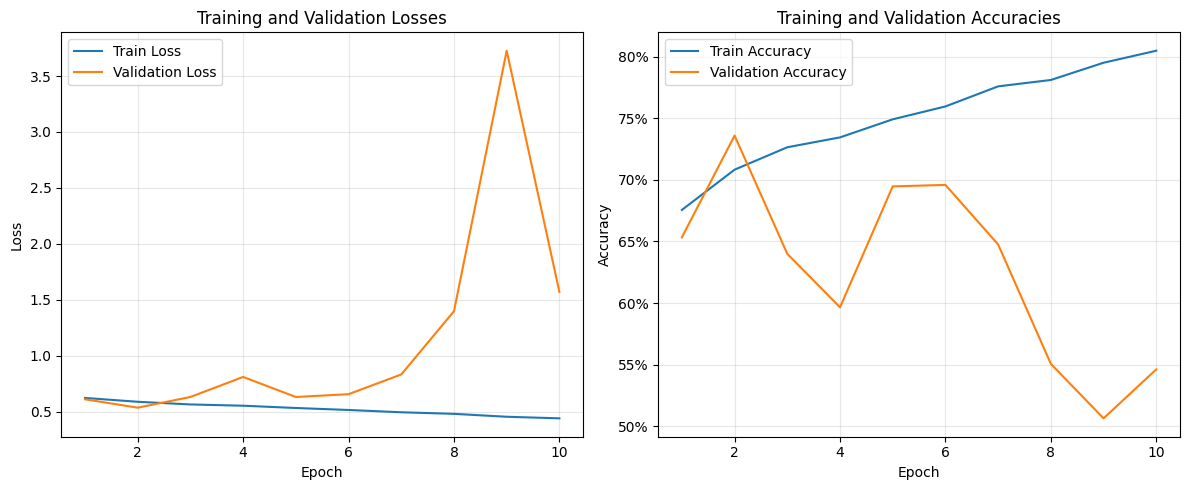

In [3]:
def load_medical_data_subset(sample_ratio=0.1, random_state=42):

    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_x.h5', 'r') as f:
        train_length = len(f['x'])
       
        sample_size = int(train_length * sample_ratio)
        indices = np.random.RandomState(random_state).choice(train_length, sample_size, replace=False)
        indices.sort()  
        
        tr_images = []
        for idx in indices:
            tr_images.append(f['x'][idx].astype(np.float32))
        tr_images = torch.from_numpy(np.array(tr_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_y.h5', 'r') as f:
        tr_targets = []
        for idx in indices:
            tr_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        tr_targets = torch.from_numpy(np.array(tr_targets))
    
   
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_x.h5', 'r') as f:
        val_length = len(f['x'])
       
        val_sample_size = int(val_length * sample_ratio)
        val_indices = np.random.RandomState(random_state).choice(val_length, val_sample_size, replace=False)
        val_indices.sort()
        
        val_images = []
        for idx in val_indices:
            val_images.append(f['x'][idx].astype(np.float32))
        val_images = torch.from_numpy(np.array(val_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_y.h5', 'r') as f:
        val_targets = []
        for idx in val_indices:
            val_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        val_targets = torch.from_numpy(np.array(val_targets))
    
    print(f"Loaded {len(tr_images)} training samples and {len(val_images)} validation samples")
    return tr_images, tr_targets, val_images, val_targets

class MedicalDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255  
        x = x.view(-1, 96*96*3) 
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)


tr_images, tr_targets, val_images, val_targets = load_medical_data_subset(sample_ratio=0.1)

train_dataset = MedicalDataset(tr_images, tr_targets)
valid_dataset = MedicalDataset(val_images, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Linear(96 * 96 * 3, 1000),
    nn.BatchNorm1d(1000),
    nn.Dropout(.6),
    nn.ReLU(),  
    nn.Linear(1000, 1000),
    nn.BatchNorm1d(1000),
    nn.Dropout(.6),
    nn.ReLU(), 
    nn.Linear(1000, 1000),
    nn.BatchNorm1d(1000),
    nn.Dropout(.6),
    nn.ReLU(),   
    nn.Linear(1000, 2)  
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

def accuracy(outputs, targets):
    _, predictions = torch.max(outputs, 1)  
    correct = (predictions == targets).sum().item()
    return correct / targets.size(0)

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)  
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)


n_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = validate(model, valid_dataloader, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True, alpha=0.3)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

Loaded 26214 training samples and 3276 validation samples
Epoch 1/10, Train Loss: 0.7247, Validation Loss: 0.5911, Train Accuracy: 0.5533, Validation Accuracy: 0.7161
Epoch 2/10, Train Loss: 0.6735, Validation Loss: 0.5653, Train Accuracy: 0.6061, Validation Accuracy: 0.7119
Epoch 3/10, Train Loss: 0.6507, Validation Loss: 0.5518, Train Accuracy: 0.6334, Validation Accuracy: 0.7104
Epoch 4/10, Train Loss: 0.6362, Validation Loss: 0.5438, Train Accuracy: 0.6471, Validation Accuracy: 0.7061
Epoch 5/10, Train Loss: 0.6251, Validation Loss: 0.5507, Train Accuracy: 0.6613, Validation Accuracy: 0.7070
Epoch 6/10, Train Loss: 0.6141, Validation Loss: 0.5439, Train Accuracy: 0.6721, Validation Accuracy: 0.7179
Epoch 7/10, Train Loss: 0.6050, Validation Loss: 0.5622, Train Accuracy: 0.6801, Validation Accuracy: 0.7052
Epoch 8/10, Train Loss: 0.6021, Validation Loss: 0.5756, Train Accuracy: 0.6841, Validation Accuracy: 0.6934
Epoch 9/10, Train Loss: 0.5923, Validation Loss: 0.5899, Train Accurac

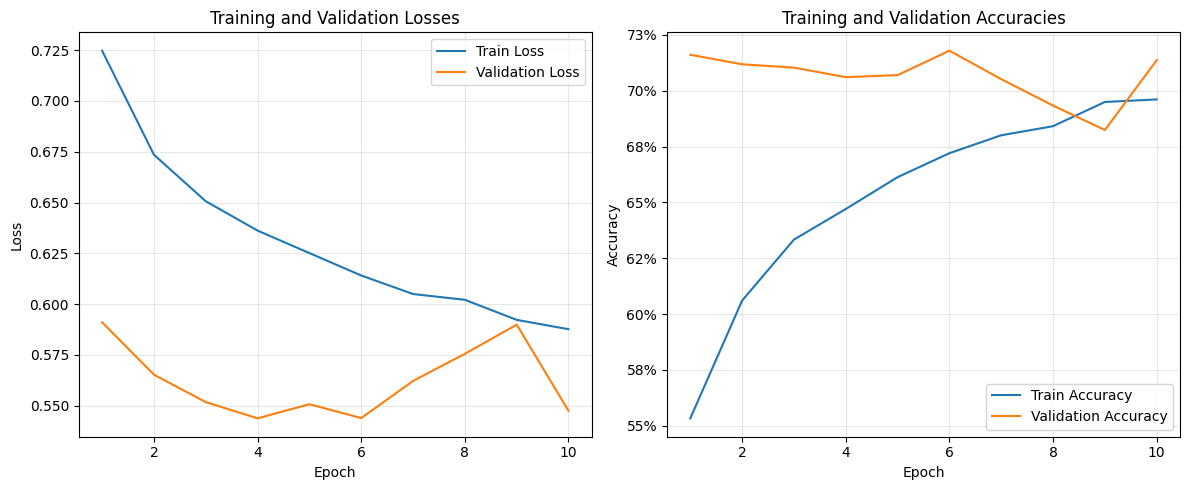

In [3]:
def load_medical_data_subset(sample_ratio=0.1, random_state=42):

    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_x.h5', 'r') as f:
        train_length = len(f['x'])
       
        sample_size = int(train_length * sample_ratio)
        indices = np.random.RandomState(random_state).choice(train_length, sample_size, replace=False)
        indices.sort()  
        
        tr_images = []
        for idx in indices:
            tr_images.append(f['x'][idx].astype(np.float32))
        tr_images = torch.from_numpy(np.array(tr_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_y.h5', 'r') as f:
        tr_targets = []
        for idx in indices:
            tr_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        tr_targets = torch.from_numpy(np.array(tr_targets))
    
   
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_x.h5', 'r') as f:
        val_length = len(f['x'])
       
        val_sample_size = int(val_length * sample_ratio)
        val_indices = np.random.RandomState(random_state).choice(val_length, val_sample_size, replace=False)
        val_indices.sort()
        
        val_images = []
        for idx in val_indices:
            val_images.append(f['x'][idx].astype(np.float32))
        val_images = torch.from_numpy(np.array(val_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_y.h5', 'r') as f:
        val_targets = []
        for idx in val_indices:
            val_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        val_targets = torch.from_numpy(np.array(val_targets))
    
    print(f"Loaded {len(tr_images)} training samples and {len(val_images)} validation samples")
    return tr_images, tr_targets, val_images, val_targets

class MedicalDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255  
        x = x.view(-1, 96*96*3) 
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)


tr_images, tr_targets, val_images, val_targets = load_medical_data_subset(sample_ratio=0.1)

train_dataset = MedicalDataset(tr_images, tr_targets)
valid_dataset = MedicalDataset(val_images, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Linear(96 * 96 * 3, 1000),
    nn.BatchNorm1d(1000),
    nn.Dropout(.6),
    nn.ReLU(),  
    nn.Linear(1000, 1000),
    nn.BatchNorm1d(1000),
    nn.Dropout(.6),
    nn.ReLU(), 
    nn.Linear(1000, 1000),
    nn.BatchNorm1d(1000),
    nn.Dropout(.6),
    nn.ReLU(),   
    nn.Linear(1000, 2)  
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

def accuracy(outputs, targets):
    _, predictions = torch.max(outputs, 1)  
    correct = (predictions == targets).sum().item()
    return correct / targets.size(0)

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)  
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)


n_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = validate(model, valid_dataloader, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True, alpha=0.3)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

Loaded 5242 training samples and 655 validation samples
Epoch 1/10, Train Loss: 0.6569, Validation Loss: 0.5594, Train Accuracy: 0.6420, Validation Accuracy: 0.7055
Epoch 2/10, Train Loss: 0.6112, Validation Loss: 0.5515, Train Accuracy: 0.6987, Validation Accuracy: 0.7061
Epoch 3/10, Train Loss: 0.5617, Validation Loss: 0.5609, Train Accuracy: 0.7234, Validation Accuracy: 0.7046
Epoch 4/10, Train Loss: 0.5400, Validation Loss: 0.5414, Train Accuracy: 0.7378, Validation Accuracy: 0.7224
Epoch 5/10, Train Loss: 0.5074, Validation Loss: 0.5774, Train Accuracy: 0.7652, Validation Accuracy: 0.6865
Epoch 6/10, Train Loss: 0.4804, Validation Loss: 0.6986, Train Accuracy: 0.7800, Validation Accuracy: 0.6540
Epoch 7/10, Train Loss: 0.4404, Validation Loss: 1.2415, Train Accuracy: 0.8056, Validation Accuracy: 0.5194
Epoch 8/10, Train Loss: 0.4175, Validation Loss: 1.2872, Train Accuracy: 0.8174, Validation Accuracy: 0.5326
Epoch 9/10, Train Loss: 0.3794, Validation Loss: 0.7233, Train Accuracy:

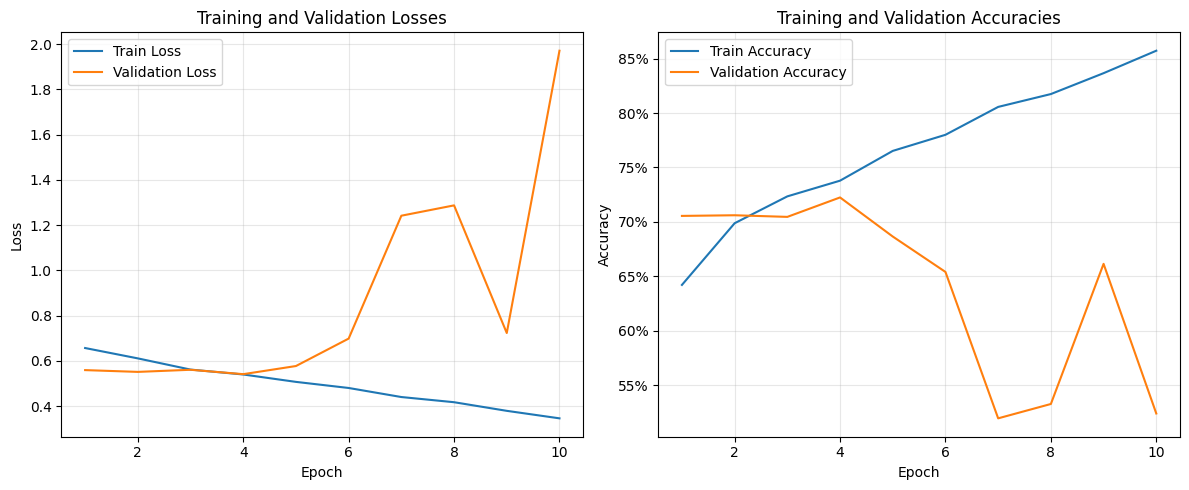

In [19]:
def load_medical_data_subset(sample_ratio=0.1, random_state=42):

    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_x.h5', 'r') as f:
        train_length = len(f['x'])
       
        sample_size = int(train_length * sample_ratio)
        indices = np.random.RandomState(random_state).choice(train_length, sample_size, replace=False)
        indices.sort()  
        
        tr_images = []
        for idx in indices:
            tr_images.append(f['x'][idx].astype(np.float32))
        tr_images = torch.from_numpy(np.array(tr_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_y.h5', 'r') as f:
        tr_targets = []
        for idx in indices:
            tr_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        tr_targets = torch.from_numpy(np.array(tr_targets))
    
   
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_x.h5', 'r') as f:
        val_length = len(f['x'])
       
        val_sample_size = int(val_length * sample_ratio)
        val_indices = np.random.RandomState(random_state).choice(val_length, val_sample_size, replace=False)
        val_indices.sort()
        
        val_images = []
        for idx in val_indices:
            val_images.append(f['x'][idx].astype(np.float32))
        val_images = torch.from_numpy(np.array(val_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_y.h5', 'r') as f:
        val_targets = []
        for idx in val_indices:
            val_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        val_targets = torch.from_numpy(np.array(val_targets))
    
    print(f"Loaded {len(tr_images)} training samples and {len(val_images)} validation samples")
    return tr_images, tr_targets, val_images, val_targets

class MedicalDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255  
        x = x.view(-1, 96*96*3) 
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)


tr_images, tr_targets, val_images, val_targets = load_medical_data_subset(sample_ratio=0.02)

train_dataset = MedicalDataset(tr_images, tr_targets)
valid_dataset = MedicalDataset(val_images, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Linear(96 * 96 * 3, 512),
    nn.BatchNorm1d(512),
    nn.Dropout(.6),
    nn.ReLU(),  
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.Dropout(.6),
    nn.ReLU(), 
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.Dropout(.6),
    nn.ReLU(),   
    nn.Linear(512, 2)  
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def accuracy(outputs, targets):
    _, predictions = torch.max(outputs, 1)  
    correct = (predictions == targets).sum().item()
    return correct / targets.size(0)

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)  
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)


n_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = validate(model, valid_dataloader, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True, alpha=0.3)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

Loaded 5242 training samples and 655 validation samples
Epoch 1/10, Train Loss: 0.7366, Validation Loss: 0.6050, Train Accuracy: 0.5485, Validation Accuracy: 0.7203
Epoch 2/10, Train Loss: 0.6966, Validation Loss: 0.5765, Train Accuracy: 0.5870, Validation Accuracy: 0.7369
Epoch 3/10, Train Loss: 0.6683, Validation Loss: 0.5980, Train Accuracy: 0.6117, Validation Accuracy: 0.7114
Epoch 4/10, Train Loss: 0.6551, Validation Loss: 0.5595, Train Accuracy: 0.6340, Validation Accuracy: 0.7231
Epoch 5/10, Train Loss: 0.6326, Validation Loss: 0.5502, Train Accuracy: 0.6513, Validation Accuracy: 0.7369
Epoch 6/10, Train Loss: 0.6143, Validation Loss: 0.5448, Train Accuracy: 0.6628, Validation Accuracy: 0.7431
Epoch 7/10, Train Loss: 0.5985, Validation Loss: 0.5549, Train Accuracy: 0.6878, Validation Accuracy: 0.7157
Epoch 8/10, Train Loss: 0.5912, Validation Loss: 0.5750, Train Accuracy: 0.6936, Validation Accuracy: 0.6980
Epoch 9/10, Train Loss: 0.5804, Validation Loss: 0.5433, Train Accuracy:

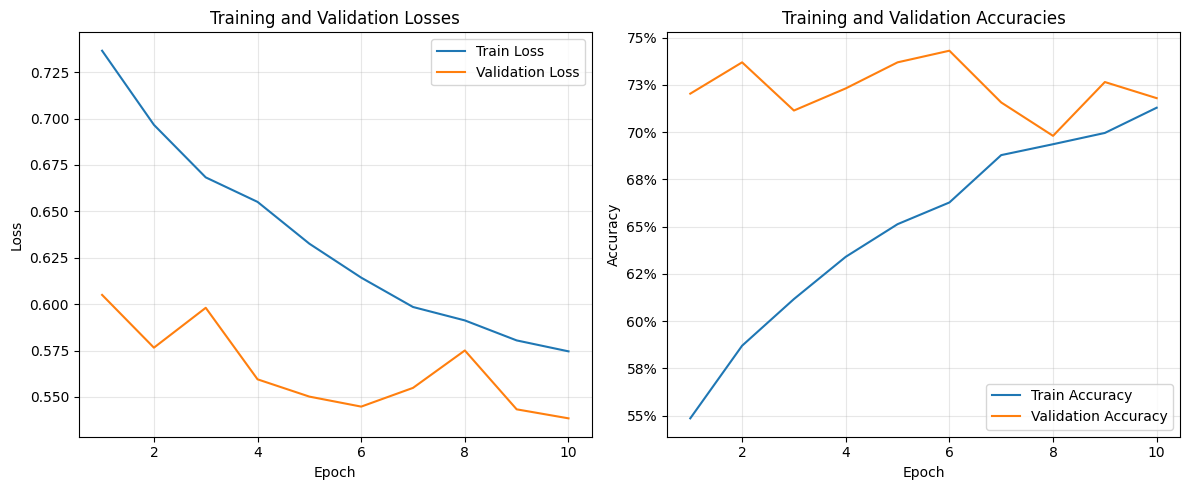

In [21]:
def load_medical_data_subset(sample_ratio=0.1, random_state=42):

    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_x.h5', 'r') as f:
        train_length = len(f['x'])
       
        sample_size = int(train_length * sample_ratio)
        indices = np.random.RandomState(random_state).choice(train_length, sample_size, replace=False)
        indices.sort()  
        
        tr_images = []
        for idx in indices:
            tr_images.append(f['x'][idx].astype(np.float32))
        tr_images = torch.from_numpy(np.array(tr_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_train_y.h5', 'r') as f:
        tr_targets = []
        for idx in indices:
            tr_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        tr_targets = torch.from_numpy(np.array(tr_targets))
    
   
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_x.h5', 'r') as f:
        val_length = len(f['x'])
       
        val_sample_size = int(val_length * sample_ratio)
        val_indices = np.random.RandomState(random_state).choice(val_length, val_sample_size, replace=False)
        val_indices.sort()
        
        val_images = []
        for idx in val_indices:
            val_images.append(f['x'][idx].astype(np.float32))
        val_images = torch.from_numpy(np.array(val_images))
    
    with h5py.File('C:/Users/pc/Desktop/tahlil dade/AI/s9/camelyonpatch_level_2_split_valid_y.h5', 'r') as f:
        val_targets = []
        for idx in val_indices:
            val_targets.append(f['y'][idx, 0, 0, 0].astype(np.int64))
        val_targets = torch.from_numpy(np.array(val_targets))
    
    print(f"Loaded {len(tr_images)} training samples and {len(val_images)} validation samples")
    return tr_images, tr_targets, val_images, val_targets

class MedicalDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255  
        x = x.view(-1, 96*96*3) 
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)


tr_images, tr_targets, val_images, val_targets = load_medical_data_subset(sample_ratio=0.02)

train_dataset = MedicalDataset(tr_images, tr_targets)
valid_dataset = MedicalDataset(val_images, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Linear(96 * 96 * 3, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(.6),
    nn.ReLU(),  
    nn.Linear(256, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(.6),
    nn.ReLU(), 
    nn.Linear(256, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(.6),
    nn.ReLU(),   
    nn.Linear(256, 2)  
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

def accuracy(outputs, targets):
    _, predictions = torch.max(outputs, 1)  
    correct = (predictions == targets).sum().item()
    return correct / targets.size(0)

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)  
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)


n_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = validate(model, valid_dataloader, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True, alpha=0.3)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

In [ ]:
def calculate_precision_recall():
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in valid_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    predictions_np = np.array(all_predictions)
    targets_np = np.array(all_targets)
  
    from sklearn.metrics import precision_score, recall_score
    
    precision = precision_score(targets_np, predictions_np, average='binary', zero_division=0)
    recall = recall_score(targets_np, predictions_np, average='binary', zero_division=0)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return precision, recall

precision, recall = calculate_precision_recall()

Precision: 0.6802
Recall: 0.7893
